In [195]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [196]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150

In [197]:
n_datasets = 4

In [198]:
metadata = dict()
filename = "3-data/1.csv"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Time (s)': 'Signal strength',
 '0.00041666667675599456': '50',
 '0.0008333333535119891': '50',
 '0.0012499999720603228': '50',
 '0.0016666667070239782': '50',
 '0.0020833334419876337': '50',
 '0.0024999999441206455': '50',
 '0.002916666679084301': '50',
 '0.0033333334140479565': '50',
 '0.0037499999161809683': '50',
 '0.004166666883975267': '50',
 '0.004583333153277636': '50',
 '0.004999999888241291': '50',
 '0.0054166666232049465': '50',
 '0.005833333358168602': '50'}

In [305]:
v = [8, 6, 2, 1.5]

datasets = [
    {
        "raw": pd.read_csv(f"3-data/{i}.csv", delimiter=",") ,
        "v": v[i]
    }
    for i in range(n_datasets)
]


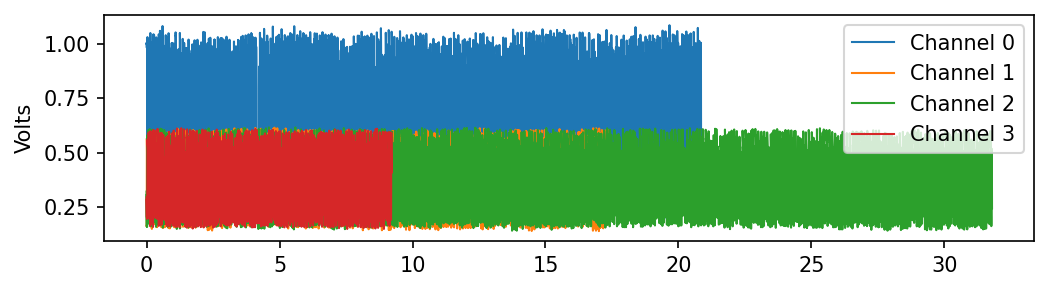

In [364]:
plt.rcParams['figure.figsize'] = [8, 2]
for (n, dataset) in enumerate(datasets):
    raw = dataset["raw"]
    t_raw = raw["Time (s)"].to_numpy()
    i_raw = raw["Intensity"].to_numpy()
    
    t = t_raw
    i = i_raw
    
    plt.plot(
        t,  i,
        label=f"Channel {n}",
        lw=1
    )
    dataset["t"] = t
    dataset["i"] = i
    plt.ylabel("Volts")
    plt.legend()

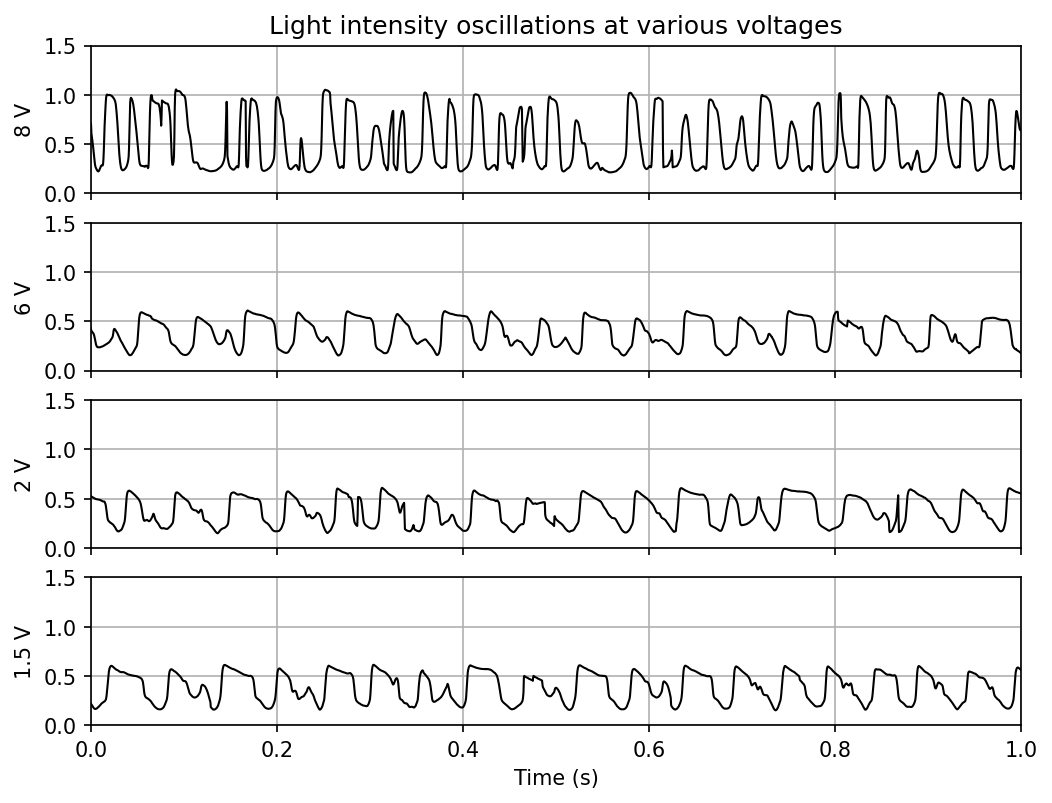

In [374]:
plt.rcParams['figure.figsize'] = [8, 6]

fig, ax = plt.subplots(n_datasets, 1, sharex=True, sharey=True)
ax[0].set_title("Light intensity oscillations at various voltages")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1.5)
ax[-1].set_xlabel("Time (s)")

for (n, data) in enumerate(datasets):
    
    t = data["t"] - 1
    i = data["i"]
    v = data["v"]
    ax[n].plot(t, i, color="black", lw=1)
            
    ax[n].set_ylabel(f"{v} V")
    ax[n].grid()

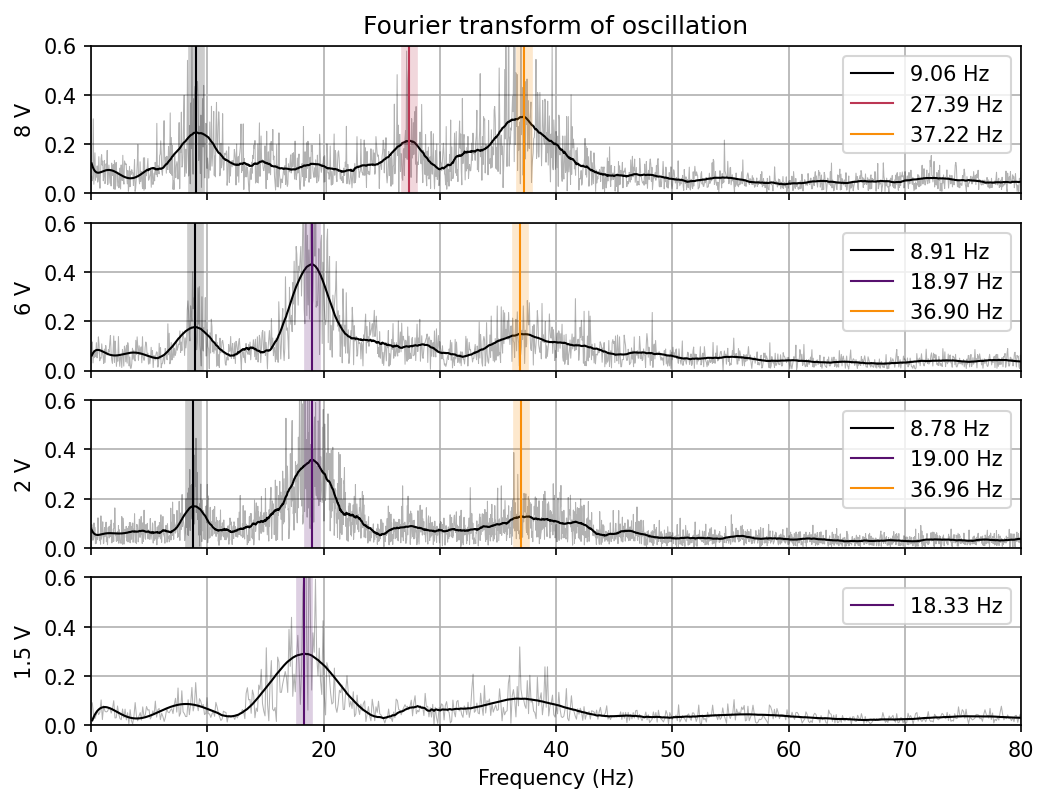

In [362]:
from scipy.fft import fft, fftfreq, fftshift
plt.rcParams['figure.figsize'] = [8, 6]

fig, ax = plt.subplots(n_datasets, 1, sharex=True, sharey=True)
ax[0].set_title("Fourier transform of oscillation")
ax[0].set_xlim(0, 80)
ax[0].set_ylim(0, 0.6)
ax[-1].set_xlabel("Frequency (Hz)")

harmonic = 9
n_harmonics = 4

cmap = plt.colormaps['inferno']

harmonics = [ { "s": [], "v": [] } for i in range(n_harmonics) ]
f_harmonic = harmonic * ( np.arange(n_harmonics) + 1)

for (n, data) in enumerate(datasets):
    t = data["t"]
    i = data["i"]
    v = data["v"]
    
    s_raw = np.abs(fftshift(fft(i - np.mean(i))))
    s_raw /= np.max(s_raw)
    
    sampling_rate = 1 / np.average(np.diff(t))
    f = fftshift(fftfreq(t.size, 1/sampling_rate))

    s_raw = s_raw[f>0]
    f = f[f>0]

    s = sp.signal.savgol_filter(s_raw, 200, 7)
    
    bin_width = np.average(np.diff(f))    

    ax[n].plot(f, s_raw, lw=0.5, c="black", alpha=0.3)
    ax[n].plot(f, s, lw=1, c="black")

    for i in range(n_harmonics):
        near = np.abs(f - f_harmonic[i]) < 2
        s_peak = 0
        if np.max(s[near]) > 0.12:
            s_peak = np.max(s[near])
            f_peak = f[near][np.argmax(s[near])]
            
            ax[n].axvline(f_peak, label=f"{f_peak:.2f} Hz", lw=1, c=cmap(i/n_harmonics))
            ax[n].axvline(f_peak, lw=8, c=cmap(i/n_harmonics), alpha=0.2)

        harmonics[i]["s"].append(s_peak)
        harmonics[i]["v"].append(v)
            
    ax[n].set_ylabel(f"{v} V")
    ax[n].grid()   
    ax[n].legend()


In [344]:
sp.signal.savgol_filter

<function scipy.signal._savitzky_golay.savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)>

In [345]:
harmonics

[{'s': [0.24686185648146916, 0.1769976824725006, 0.16982764139234596, 0],
  'v': [8, 6, 2, 1.5]},
 {'s': [0, 0.43140526022307496, 0.35824959614944046, 0.2894984768176332],
  'v': [8, 6, 2, 1.5]},
 {'s': [0.21338271981361664, 0, 0, 0], 'v': [8, 6, 2, 1.5]},
 {'s': [0.311573499781131, 0.1492609893425453, 0.12780140842725937, 0],
  'v': [8, 6, 2, 1.5]}]

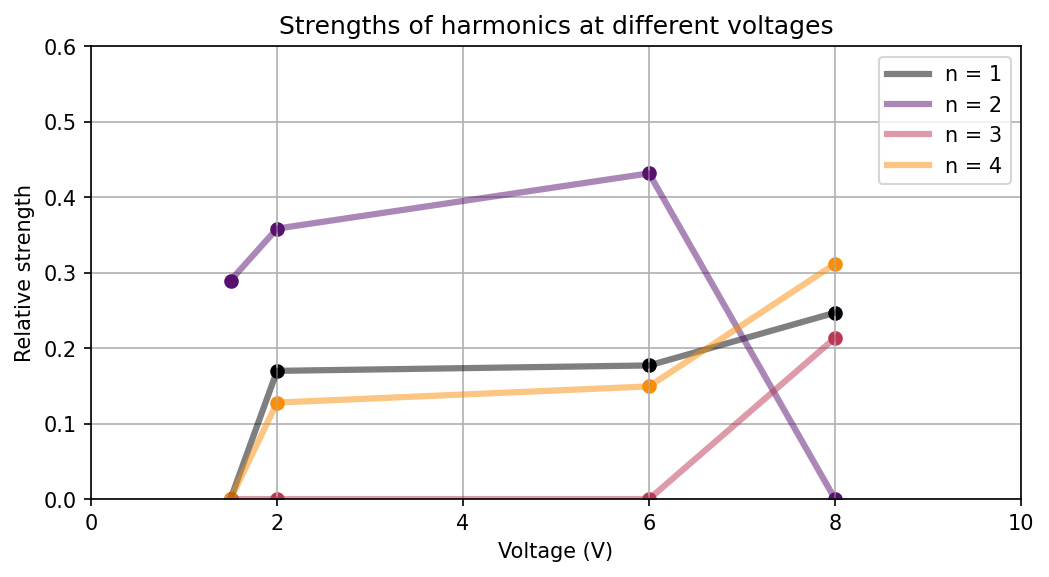

In [355]:
plt.rcParams['figure.figsize'] = [8, 4]

for (n, harmonic) in enumerate(harmonics):
    s = harmonic["s"]
    v = harmonic["v"]
    plt.scatter(v, s, color=cmap(n/n_harmonics))
    plt.plot(v, s, label=f"n = {n+1}", color=cmap(n/n_harmonics), alpha=0.5, lw=3)

plt.ylabel("Relative strength")
plt.xlabel("Voltage (V)")
plt.xlim(0, 10)
plt.ylim(0,0.6)
plt.margins(0)
plt.grid()
plt.title("Strengths of harmonics at different voltages")

plt.legend()